# Data Analysis and Machine Learning Applications for Physicists

*Material for a* [*University of Illinois*](http://illinois.edu) *course offered by the* [*Physics Department*](https://physics.illinois.edu). *This content is maintained on* [*GitHub*](https://github.com/illinois-mla) *and is distributed under a* [*BSD3 license*](https://opensource.org/licenses/BSD-3-Clause).

[Table of contents](Contents.ipynb)

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sns; sns.set()
import numpy as np
import pandas as pd
import warnings
warnings.filterwarnings('ignore')

In [2]:
import scipy.linalg

In [3]:
from mls import locate_data

In [4]:
from sklearn import linear_model

## Supervised Learning in Scikit Learn

The sklearn supervised learning functions are organized into several modules:
 - [linear_model](http://scikit-learn.org/stable/modules/linear_model.html): regression with [generalized linear models](https://en.wikipedia.org/wiki/Generalized_linear_model).
 - [kernel_ridge](http://scikit-learn.org/stable/modules/kernel_ridge.html): ridge regression using the kernel trick.
 - [svm](http://scikit-learn.org/stable/modules/svm.html): regression, classification (and outlier detection) with [support vector machines](https://en.wikipedia.org/wiki/Support_vector_machine).
 - [tree](http://scikit-learn.org/stable/modules/tree.html): regression and classification using [decision trees](https://en.wikipedia.org/wiki/Decision_tree).
 - [discriminant_analysis](http://scikit-learn.org/stable/modules/lda_qda.html): classification using [linear](https://en.wikipedia.org/wiki/Linear_discriminant_analysis) and [quadratic](https://en.wikipedia.org/wiki/Quadratic_classifier) discriminant analysis.
 - [ensemble](http://scikit-learn.org/stable/modules/ensemble.html): regression, classification (and anomaly detection) using [ensemble methods](https://en.wikipedia.org/wiki/Ensemble_learning).
 - [gaussian_process](http://scikit-learn.org/stable/modules/gaussian_process.html): regression and classification using [Gaussian processes](https://en.wikipedia.org/wiki/Gaussian_process).
 - [naive_bayes](http://scikit-learn.org/stable/modules/naive_bayes.html): Bayesian classification with [oversimplified assumptions](https://en.wikipedia.org/wiki/Naive_Bayes_classifier).
 
More esoteric and less used supervised learning modules:
 - [isotonic](http://scikit-learn.org/stable/modules/isotonic.html): regression using an [isotonic model](https://en.wikipedia.org/wiki/Isotonic_regression).
 - [multiclass and multioutput](http://scikit-learn.org/stable/modules/multiclass.html): meta-estimators that enhance a base estimator.
 - [neural_network](http://scikit-learn.org/stable/modules/neural_networks_supervised.html): we will use [tensorflow](https://www.tensorflow.org/) instead to implement neural networks algorithms.

Finally, useful infrastructure for supervised learning:
 - [preprocessing](http://scikit-learn.org/stable/modules/preprocessing.html): prepare your data before learning from it.
 - [pipeline](http://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline): utilities to chain together estimators (and preprocessing) into a single pipeline.
 - [model_selection](http://scikit-learn.org/stable/modules/cross_validation.html): model selection (hyper-parameter tuning) via cross validation.

Since regression problems are more common in scientific applications, we will focus on them here. Our [earlier introduction](Learning.ipynb) of supervised learning used a probabilistic language where the solution is given by a distribution

$$ \Large
P(Y'\mid X,Y,X',M) \; .
$$

Stated differently, our goal is, given a training set of random variables X and Y (i.e. D), to learn a function h : X 􏰀→ Y so that h(x) is a “good” predictor for the corresponding value of y. For historical reasons, this function h is called a **hypothesis**.

When the target variable that we are trying to predict is continuous, we call the learning problem a **regression** problem. When Y can take on only a small number of discrete values, we call it a **classification** problem.

Unfortunately, most sklearn algorithms give only limited information about this distribution, since they only return an estimate of its central tendency (mean / median / mode / ...):

$$ \Large
P(Y'\mid X,Y,X',M) \;\rightarrow\; Y'(X,Y,X',M) \simeq \langle Y' \rangle_{P(Y'\mid X,Y,X',M)} \; .
$$

In practice, if you need to make probabilistic statements about what you have learned from a regression, your best choices among the sklearn algorithms are:
 - [Linear regression](https://en.wikipedia.org/wiki/Generalized_linear_model) to model (approximately) linear relationships.
 - [Gaussian process regression](http://scikit-learn.org/stable/modules/gaussian_process.html) to model non-linear relationships.

### Linear Regression

Ordinary linear regression predicts the expected value of a given unknown quantity (the response variable, a random variable) as a linear combination of a set of observed values (predictors). This implies that a constant change in a predictor leads to a constant change in the response variable (i.e. a linear-response model).

A standard linear regression assumes the observed data $D = (X,Y)$ is explained by the model,

$$ \Large
Y = X W + \delta Y \; ,
$$

where, in general, all quantities are matrices, the model parameters are the elements of $W$, and $\delta Y$ is the "noise" inherent in $Y$.

**EXERCISE:** Assume that $X$ consists of $N$ samples of $n$ features, represented by a $N\times n$ matrix, and $Y$ consists of $N$ samples of $m$ features, represented by a $N\times m$ matrix.  What are the dimensions of the matrices for $W$ and $\delta Y$?

$W$ must be $n\times m$, in order that the matrix product $X W$ has the shape $N\times m$.

$\delta Y$ must have the same shape as $Y$: $N\times m$.

When $m=1$, the linear regression problem is usually written with lower-case notation:

$$ \Large
y = X w + \delta y \; .
$$

---

We further assume that:
 - There is no (or negligible) noise in $X$.
 - Each feature in $Y$ has zero mean, i.e., `np.mean(Y, axis=0) = 0`.
 
If the last condition is not met, we could simply subtract the mean before applying this model,
```
Y -= np.mean(Y, axis=0)
```
but we will see that sklearn will do this automatically for you.

By definition, "noise" is unbiased,

$$ \Large
\langle \delta Y\rangle = 0 \; ,
$$

and uncorrelated with $X$,

$$ \Large
\langle \delta Y^T\,X\rangle = 0 \; .
$$

The noise is usually assumed to be Gaussian but, in the most general case, this is complex to model since there are potentially $n^2 m^2$ covariances (only ~half of which are independent),

$$ \Large
\langle \delta Y_{ij} \delta Y_{pq}\rangle \; ,
$$

to account for:
 - different variances for each of the $m$ features in $Y$, and
 - correlations between the $m$ features in $Y$, and
 - correlations between the $N$ samples in $Y$.

In practice, the most general problem we solve is when

$$ \Large
\langle \delta Y_{ip} \delta Y_{jq}\rangle = C_{ij} \; ,
$$

i.e., all $m$ features have the same variance $C_{ii}$ for sample $i$, but samples are potentially correlated.  The resulting $n\times n$ "sample covariance matrix" $C$ then specifies the likelihood

$$ \large
P(X,Y\mid W, C) = \prod_{k=1}^m\, \left(2\pi C\right)^{-1/2}\,
\exp\left[ -\frac{1}{2} (Y - X W)_k^T C^{-1} (Y - X W)_k\right] \; ,
$$

where $(Y - X W)_k$ is the column of $N$ values (one per sample) for the $k$-th feature of $Y$. Note that we treat the elements of $C$ as fixed hyperparameters in standard linear regression.

A important special case occurs when all samples (and features) have the same variance $\sigma^2$,

$$ \Large
C = \sigma^2 {\mathbb 1}_{n\times n} \; ,
$$

which we refer to as **homoscedastic** errors.  Any type of non-homescedastic errors are called **heteroscedastic**.

#### Example: fitting a line

Read our `line_data` dataset:

In [5]:
D = pd.read_csv(locate_data('line_data.csv'))
X = D['x'].values.reshape(-1, 1)
y = D['y'].values
y_true = pd.read_csv(locate_data('line_targets.csv'))['y_true'].values

The `LinearRegression` function solves the [linear least squares problem](https://en.wikipedia.org/wiki/Linear_least_squares_%28mathematics%29) by minimizing sum of squared residuals

$$ \Large
S \equiv \sum_{i=1}^N \left| Y_i - (X W)_i \right|^2
$$

with respect to the model parameters (elements of $W$), where $i$ indexes the $N$ samples in the dataset. The syntax will be familiar from the sklearn functions we used earlier:

In [6]:
fit = linear_model.LinearRegression(fit_intercept=True).fit(X, y)

Note that `LinearRegression` will automatically calculate and subtract any non-zero mean of $y$ when `fit_intercept` is `True`.

The resulting $W$ matrix has only a single element, the slope of the line (which is assumed to pass through the origin):

In [7]:
W = fit.coef_
y0 = fit.intercept_

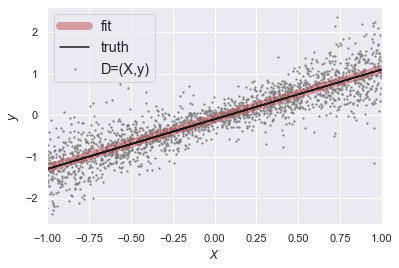

In [8]:
plt.scatter(X[:, 0], y, label='D=(X,y)', lw=0, s=5, c='gray')
plt.plot(X[:, 0], X.dot(W) + y0, 'r-', lw=8, alpha=0.5, label='fit')
plt.plot(X[:, 0], y_true, 'k-', label='truth')
plt.legend(fontsize='x-large')
plt.xlabel('$X$')
plt.ylabel('$y$')
plt.xlim(-1., +1.);

In our probabilistic language, `LinearRegression` finds the maximum likelihood (ML) point estimate assuming homoscedastic Gaussian errors. This can also be interpreted as a maximum a-posteriori (MAP) point estimate if we believe that the priors should all be uniform.

This ML solution can be found directly using linear algebra (which makes linear regression a very special case of supervised learning):

$$ \Large
W = (X^T X)^{-1} X^T Y \; .
$$

Note that the solution does not depend on the homoscedastic error $\sigma$.

**EXERCISE:** Explain why we cannot simplify this expression using:

$$ \Large
(X^T X)^{-1} = X^{-1} (X^T)^{-1} \; \Rightarrow \; W = X^{-1} Y \; .
$$

This is only valid when $X$ is a square matrix, $N = n$, in which case finding $W$ reduces to solving a system of $N$ linear equations in $N$ unknowns. In the more general case where $N > n$, we have an overdetermined system of equations and seek the best compromise solution given the expected errors. If $N < n$, the problem is underdetermined and $X^T X$ is not invertible.

---

We can also directly solve the more general problem of Gaussian errors described by an $n\times n$ sample covariance $C$:

$$ \Large
W = (X^T C_N X)^{-1} X^T C_N^{-1} Y
$$

However, the `LinearRegression` function can only solve the case where $C$ is diagonal, i.e., each sample has a different variance but samples are uncorrelated:

In [9]:
Dvalid = D.dropna()
X = Dvalid['x'].values.reshape(-1, 1)
y = Dvalid['y'].values
dy = Dvalid['dy'].values

Pass the diagonal elements of $C$ as the third argument to the `fit` method:

In [10]:
fit_w = linear_model.LinearRegression().fit(X, y, dy ** 2)
W_w = fit_w.coef_ 
y0_w = fit_w.intercept_

The weighted fit finds a slightly different solution since we are now giving more weight to observations near $x = 0$ where $\sigma^2$ is smaller.

In [11]:
print(np.round([W, W_w], 3))

[[1.194]
 [1.187]]


A `LinearRegression` fit can apply what is has learned to predict new data:

In [12]:
X_new = np.array([[-1], [0], [+1]])
y_new = fit_w.predict(X_new)

Not surprisingly, the predicted $y$ values lie on the straight-line fit:

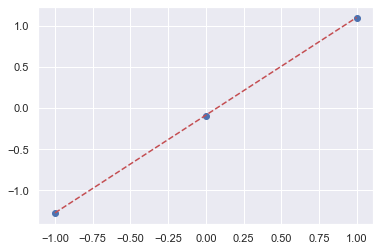

In [13]:
slope = W_w[0]
plt.scatter(X_new[:, 0], y_new);
plt.plot([-1, +1], [y0-slope, y0+slope], 'r--');

These are mean point estimates of $Y'$ given new $X'$, so of limited use when you want to make probabilistic statements about what your have learned.  However, the likelihood is Gaussian in the model parameters:

$$ \Large
P(X, Y\mid W, C) = \prod_{k=1}^m\, \left(2\pi E\right)^{-1/2}\,
\exp\left[ -\frac{1}{2} (W - W_0)_k^t E^{-1} (W - W_0)_k\right] \; ,
$$

where $W_0$ is the ML weight matrix, $(W - W_0)_k$ is the $k$-th column with $n$ rows, and $E$ is its $n\times n$ covariance, given by:

$$ \Large
E = (X^T C X)^{-1} \; .
$$
For homoscedastic errors $\sigma$, this reduces to

$$ \Large
E = \sigma^{-2} (X^T X)^{-1} \; .
$$

Unfortunately, the `LinearRegression` fit does not calculate these errors for you, but they are straightforward to calculate yourself, for example:

In [14]:
C = np.diag(dy ** 2)
E = np.linalg.inv(np.dot(X.T, np.dot(C, X)))

In this simple example, E is a $1 \times 1$ matrix containing the variance of the slope:

In [15]:
dslope = np.sqrt(E[0,0])

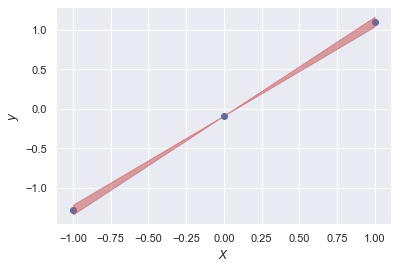

In [16]:
plt.scatter(X_new[:, 0], y_new);
plt.fill_between([-1, +1], [y0-slope+dslope, y0+slope-dslope],
                 [y0-slope-dslope, y0+slope+dslope], color='r', alpha=0.5)
plt.xlabel('$X$')
plt.ylabel('$y$');

Note that we are not propagating the uncertainty in $y_0$ here.

#### Example: linear deconvolution

The examples above have a large $N$ but only one feature in $X$ and $Y$, $n=m=1$, so that $W$ is just a single number, the slope of the line.  For a more complex example, suppose we have an instrument with an unknown response, $R(t,t')$, that transforms each input pulse $z(t)$ into an output pulse via convolution

$$ \Large
z'(t) = \int dt' R(t-t') \, z_{in}(t') \; .
$$

If we discretize time, $t_k = k \Delta t$, then the corresponding discrete response model is linear:

$$ \Large
z'_i = \sum_j R_{ij} z_j \; ,
$$

with $R_{ij} = R(t_i - t_j)$.

Generate some pulse data with a smooth Gaussian response:

In [17]:
def plot_response(R, ax):
    lim = np.percentile(np.abs(R), 99)
    img = ax.imshow(R, interpolation='none', cmap='bwr', vmin=-lim, vmax=+lim)
    plt.colorbar(img, ax=ax, orientation='horizontal', pad=0.01, fraction=0.1)
    ax.axis('off')

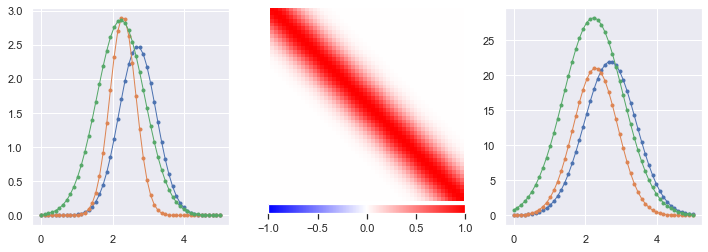

In [18]:
def generate(N=5000, n=50, tlo=0, thi=5, nplot=3, sigma_y = 0., seed=123):
    gen = np.random.RandomState(seed=seed)
    t_range = thi - tlo
    t0 = gen.uniform(tlo + 0.4 * t_range, thi - 0.4 * t_range, size=(N, 1))
    sigma = gen.uniform(0.05 * t_range, 0.15 * t_range, size=(N, 1))
    y0 = 1 + gen.rayleigh(size = (N, 1))
    t_grid = np.linspace(tlo, thi, n)
    X = y0 * np.exp(-0.5 * (t_grid - t0) ** 2 / sigma ** 2)
    r = np.exp(-0.5 * t_grid ** 2 / (t_range / 10) ** 2)
    R = scipy.linalg.toeplitz(r)
    Y = X.dot(R)
    Y += gen.normal(scale=sigma_y, size=Y.shape)
    fig, ax = plt.subplots(1, 3, figsize=(12, 4))
    for i in range(nplot):
        ax[0].plot(t_grid, X[i], '.-', lw=1)
        ax[2].plot(t_grid, Y[i], '.-', lw=1)
    plot_response(R, ax[1])
    return X, Y
    
X, Y = generate()

**EXERCISE:** With $n$ features (timesteps) in the input data $X$ and the same number $m=n$ of features in the target data $Y$, what is the minimum number of samples required to estimate the instrument response matrix $R$?

The response matrix has $n m = n^2$ unknown parameters. While there are symmetries in $R$ that could reduce this number significantly, a linear regression does not know about these symmetries.

Each of the $N$ samples provides an independent linear equation in the unknown parameters. Therefore, the problem has an exact solution when $N = n^2$ in the absence of any noise. When $N < n^2$, the problem is formally ill-determined since $X^T X$ is not invertible. However, a solution is still possible using a [pseudo matrix inverse](https://en.wikipedia.org/wiki/Moore%E2%80%93Penrose_inverse) and sometimes gives reasonable results.

With $N > n^2$, the problem is overdetermined, but we could expect additional samples to improve the answer when noise is present.

---

Try fitting with $N = 2 n^2$, $N = n^2$ or $N = n$:

In [19]:
n = X.shape[1]
fit1 = linear_model.LinearRegression(fit_intercept=False).fit(X, Y)
fit2 = linear_model.LinearRegression(fit_intercept=False).fit(X[:n**2], Y[:n**2])
fit3 = linear_model.LinearRegression(fit_intercept=False).fit(X[:n], Y[:n])
R1, R2, R3 = fit1.coef_, fit2.coef_, fit3.coef_

The results look reasonable in all cases, although there are some artifacts visible in the underdetermined solution:

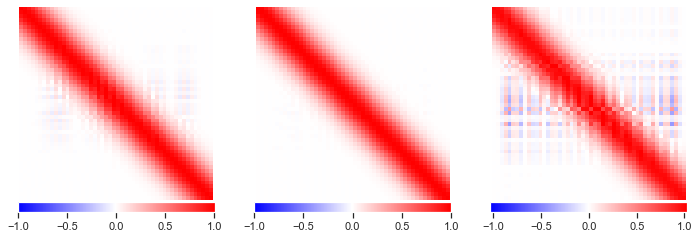

In [20]:
def plot_responses(*Rlist):
    n = len(Rlist)
    fig, ax = plt.subplots(1, n, figsize=(4 * n, 4))
    for i, R in enumerate(Rlist):
        plot_response(R, ax[i])
        
plot_responses(R1, R2, R3)

The examples above have no noise in $Y$ (except for tiny round-off errors) so now try adding some noise:

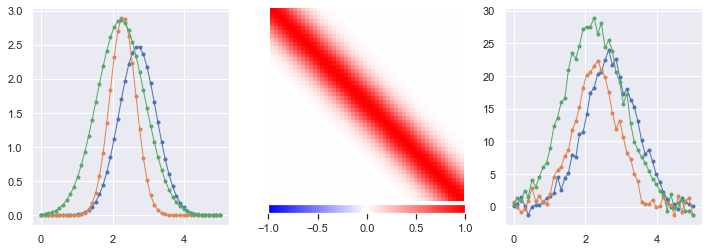

In [21]:
X, Y = generate(sigma_y=1)

In [22]:
fit1 = linear_model.LinearRegression(fit_intercept=False).fit(X, Y)
fit2 = linear_model.LinearRegression(fit_intercept=False).fit(X[:n**2], Y[:n**2])
fit3 = linear_model.LinearRegression(fit_intercept=False).fit(X[:n], Y[:n])
R1, R2, R3 = fit1.coef_, fit2.coef_, fit3.coef_

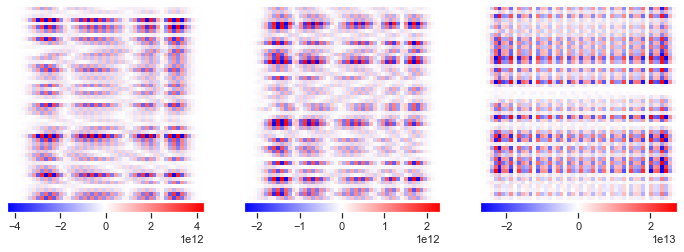

In [23]:
plot_responses(R1, R2, R3)

This clearly not what we are looking for, so what happened?  The problem is that the solution amplifies noise and finds a "best" solution that involves large cancellations between positive (red) and negative (blue) values (notice the $10^{12}$ in the colorbar scale!)  This is not a problem that more samples can easily cure.

However, the true response is still a near-optimal solution but just very unlikely to be the most optimum solution when noise is present. In a Bayesian framework, this is when we would introduce a prior for our belief that a valid solution should be "smooth" and not require these large cancellations.  Classical regression methods (and sklearn) refer to these priors as "regularization terms", but they amount to the same thing.

**Regularization** is implemented as a penalty term $R$ that we add to the least-squares score $S$ defined above:

$$ \Large
S \equiv \sum_{i=1}^N \left| Y_i - (X W)_i \right|^2 \;\rightarrow\;
S + R \; .
$$

The most common approach is to penalize using

$$ \Large
R = \alpha \sum_{i=1}^N \left| W_i \right|^2 \; ,
$$

which goes by several names including [Tikhanov regularization](https://en.wikipedia.org/wiki/Tikhonov_regularization) and [ridge regression](http://scikit-learn.org/stable/modules/linear_model.html#ridge-regression).  Note that this introduces a hyperparameter $\alpha$ which controls the strength of the regularization (prior) relative to the optimal solution (likelihood):

In [24]:
alpha = 0.1
fit1 = linear_model.Ridge(fit_intercept=False, alpha=alpha).fit(X, Y)
fit2 = linear_model.Ridge(fit_intercept=False, alpha=alpha).fit(X[:n**2], Y[:n**2])
fit3 = linear_model.Ridge(fit_intercept=False, alpha=alpha).fit(X[:n], Y[:n])
R1, R2, R3 = fit1.coef_, fit2.coef_, fit3.coef_

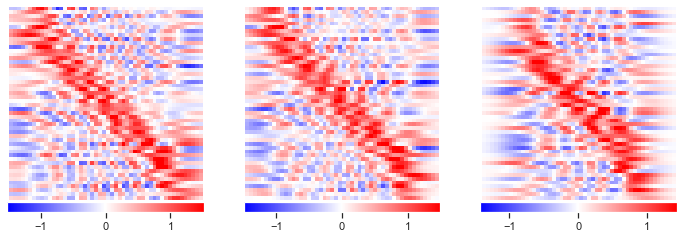

In [25]:
plot_responses(R1, R2, R3)

This has eliminated the wild fluctuations around $\pm 10^{12}$ but is still noisy. Note how additional data now improves the solution, especially in the corners.

Try again with stronger regularization (priors):

In [26]:
alpha = 10.
fit1 = linear_model.Ridge(fit_intercept=False, alpha=alpha).fit(X, Y)
fit2 = linear_model.Ridge(fit_intercept=False, alpha=alpha).fit(X[:n**2], Y[:n**2])
fit3 = linear_model.Ridge(fit_intercept=False, alpha=alpha).fit(X[:n], Y[:n])
R1, R2, R3 = fit1.coef_, fit2.coef_, fit3.coef_

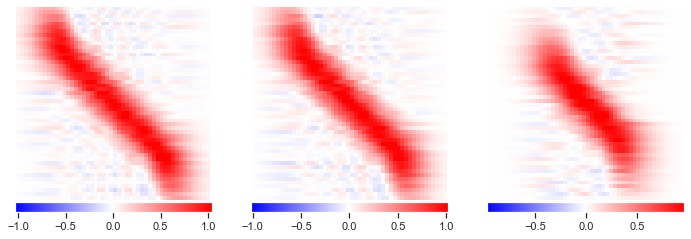

In [27]:
plot_responses(R1, R2, R3)

The sum of squares used in $S$ and $R$ above is called an [L2 norm](https://en.wikipedia.org/wiki/Norm_%28mathematics%29#Euclidean_norm) and measures the usual Euclidean distance:

$$ \Large
\|\vec{x}\|_2 = \sqrt{\sum_i x_i^2} \; .
$$

Other norms are possible but generally more difficult to work with. The L0 norm is particularly interesting because it simply counts the number of non-zero elements in $W$ so directly measures how sparse the solution is.  The L1 norm,

$$ \Large
\|\vec{x}\|_1 = \max_i |x_i| \; ,
$$

is almost as good for measuring sparsity and much easier to optimize over than the L0 norm. (There has been a lot of recent interest in L0 and L1 norms in the context of [compressed sensing](https://en.wikipedia.org/wiki/Compressed_sensing).)

The "lasso" regression algorithm uses an L1 regularization term:

$$ \Large
R = \alpha ||W||_1
$$

and is also implemented in sklearn (but noticeably slower):

In [28]:
alpha = 0.001
fit1 = linear_model.Lasso(fit_intercept=False, alpha=alpha).fit(X, Y)
fit2 = linear_model.Lasso(fit_intercept=False, alpha=alpha).fit(X[:n**2], Y[:n**2])
fit3 = linear_model.Lasso(fit_intercept=False, alpha=alpha).fit(X[:n], Y[:n])
R1, R2, R3 = fit1.coef_, fit2.coef_, fit3.coef_

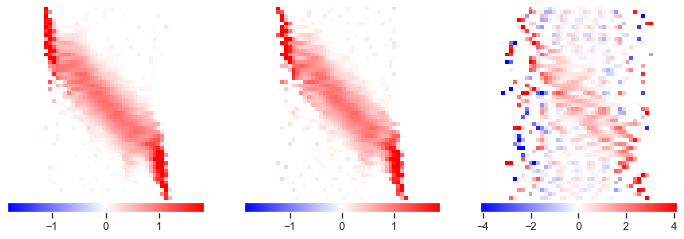

In [29]:
plot_responses(R1, R2, R3)

The results are indeed sparse, but that is probably not the best prior to use in this problem.

For more regularization options, look at [ElasticNet](http://scikit-learn.org/stable/modules/linear_model.html#elastic-net) which combines both L2 and L1 terms.

#### Example: basis function linear regression

For our final example, we will see how "linear" regression can solve problems that appear quite nonlinear. Suppose our model is

$$ \Large
Y = a X e^{-X^2} + b \sin X^2 + \delta Y
$$

with unknown parameters $a$ and $b$:

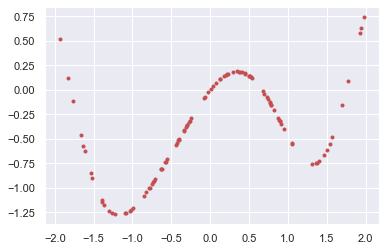

In [30]:
def generate(N=100, xlo=-2, xhi=2, a=1, b=-1, seed=123):
    gen = np.random.RandomState(seed=seed)
    X = gen.uniform(xlo, xhi, N)
    y = a * X * np.exp(-X ** 2) + b * np.sin(X ** 2)
    plt.plot(X, y, 'r.')
    return X, y

X, y = generate()

If we replace the $N\times 1$ dataset $X$ with a $N\times 2$ dataset $Z$ of new features $(Z_1, Z_2)$:

$$ \Large
Z_1 = X e^{-X^2}  \quad, \quad Z_2 = \sin X^2 \; ,
$$

the transformed model is now linear:

$$ \Large
Y = X W
$$

with
$$ \Large
W = \begin{bmatrix}
a \\ b
\end{bmatrix} \; .
$$

The new features $Z_1$ and $Z_2$ are known as "basis functions" and this approach is called "basis function regression".  Sklearn has built-in support for [polynomial basis functions](http://scikit-learn.org/stable/modules/linear_model.html#polynomial-regression-extending-linear-models-with-basis-functions) but it is easy to apply the transformations yourself for arbitrary basis functions:

In [31]:
Z = np.stack([X * np.exp(-X ** 2), np.sin(X ** 2)], axis=1)
Z.shape

(100, 2)

In [32]:
fit = linear_model.LinearRegression(fit_intercept=False).fit(Z, y)
print(fit.coef_)

[ 1. -1.]


**DISCUSS:** Suppose we have a multiplicative model for our data,

$$ \Large
y = A x_1^a x_2^b \; ,
$$

would it be valid to transform $y \rightarrow \log y$ and treat this as a linear regression problem?

Since
$$
\log y = \log A + a \log x_1 + b \log x_2 \; ,
$$
we could use
$$
Z = \log X
$$
and solve for $a$ and $b$ as linear-regression coefficients.  This is a useful trick, but with an important caveat: the linear regression solution assumes Gaussian uncertainties in $y$, but after this transform you would need Gaussian uncertainties in $\log y$.  In particular, if your original uncertainties in $y$ were Gaussian, they will not be Gaussian in $\log y$.

Note that the uncertainties are not an issue when we only transform $X$ since we assume $X$ is noise free.

---